## Recap

In the previous page, we learned how we can vectorize content into *embeddings* and use those embeddings to find similar content.

## Goals

The primary goal of this page is to expound more on implementation details on how we can create a more powerful content recommendation system. This page will be a bit of a hodge-podge of thoughts that I have to improve upon the algorithm I showcased in the previous page.

## Learning Rate - Constant or not?

In the previous page and demo, I specified learning rates $\alpha$ and $\beta$ as constants. But my thought was, what if we get rid of this constraint and use it to our advantage?

When a new user spawns in the content recommendation system, it does not know much about that user. It needs to somehow get a boost to learn faster. But how can we achieve that? We can view an embedding vector as a statistical representation of *who we think the user is* for user's embedding, or *what the data is like* for a data's description embedding. We can also view each and every feedback the user provides as a statistical *experiment*.

We can use *standard error* to play a factor in our learning rate.

$$
\sigma_{\bar{x}} = \frac{\sigma}{\sqrt{N}}
$$

where,
* $n$ is the number of experiments
* $\sigma$ is the standard deviation, which we don't know, but that does not really matter (see later)
* $\sigma_\bar{x}$ is the standard deviation of all of our observations

When an embedding is initially onboarded, there are a total of $0$ experiments on it. Thus,

$$
\sigma_\bar{x} = \frac{\sigma}{\sqrt{0}}
$$

But wait, that's undefined since we are dividing by zero! But looking at its limit,

$$
\lim\limits_{N\to 0} \left( \frac{\sigma}{\sqrt{0}} \right) = \infty
$$

We can fix this by adding a positive bias to the fraction:

$$
\sigma_\bar{x} = \frac{\sigma}{\sqrt{0} + \epsilon}
$$

Where $\epsilon$ is a tiny positive number which has the job of ensuring we can never divide by zero.

But how can we use this to control our learning rate? We know that as $n$ increases, the *population standard deviation, $\sigma_\bar{x}$ will decrease, reducing our learning rate. Thus, we can control our learning rate from the standard error. Fully put together, this turns into:

$$
\operatorname{lr}(N) = \max \left( \alpha_\text{min}, \frac{\alpha}{\sqrt{N} + \epsilon} \right)
$$

And $\epsilon = 2.0$ works really well. Let's see how this behaves!

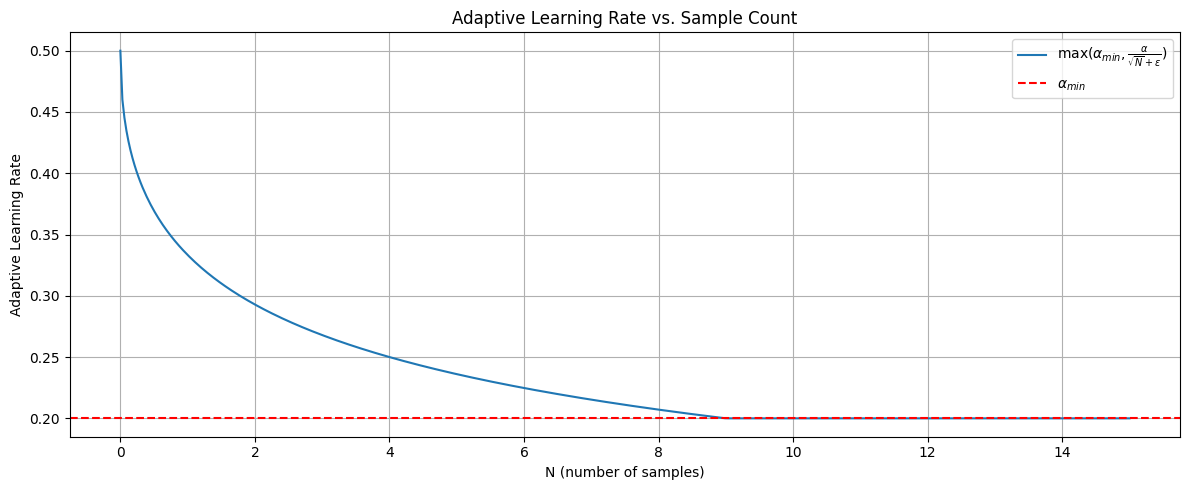

alpha = 1.0, alpha_min = 0.2, epsilon = 2


In [10]:
#% hidecode

import numpy as np
import matplotlib.pyplot as plt

# Params
alpha = 1.0
alpha_min = 0.2
epsilon = 2

# N values (sample count)
N = np.linspace(0, 15, 500)

# Compute adaptive alpha
adaptive_alpha = np.maximum(alpha_min, alpha / (np.sqrt(N) + epsilon))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(N, adaptive_alpha, label=r'$\max(\alpha_{min}, \frac{\alpha}{\sqrt{N} + \epsilon})$')
plt.axhline(alpha_min, color='red', linestyle='--', label=r'$\alpha_{min}$')
plt.xlabel('N (number of samples)')
plt.ylabel('Adaptive Learning Rate')
plt.title('Adaptive Learning Rate vs. Sample Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'alpha = {alpha}, alpha_min = {alpha_min}, epsilon = {epsilon}')

Notice how we $\max(\alpha_\text{min}, \cdots)$ ensures our learning rate never goes to zero so we our recommendations system can keep learning? By using this, the first few experiments the user does will lead to the system learning much more, helping it achieve steady state faster!

## Keeping Recommendations Interesting

Assuming the content enrolled in the system stays constant and consistent, if we query similarity for a user multiple times, we will get the same result. No one wants to see the exact same content and recommendations over and over again. Additionally, we want to create opportunities for the algorithm to recommend something different from the user's typical choices, leading to high higher value learning!

$$
\hat{V}_\text{noisy} = \hat{V}_\text{user} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma_{\text{noise}}^2)
$$

Where,
* $\epsilon$ is a noise vector
* Each element $\epsilon_i \sim \quad \epsilon \sim \mathcal{N}(0, \sigma_{\text{noise}}^2)$

The goal of the random noise is to add enough perturbation to the algorithm to keep its recommendations different, yet relevant. This means, we need to be careful of how much noise we add.

## Some Issues I Forsee

### People's Interests are not Simple

People's interests are multimodal. When it comes to movies, sometimes I enjoy watching comedies. Other times, I like watching dramas. This algorithm currently has no flexibility to effectively carry this concern.

This could likely be alleviated by maintaining a second vector along with the user's embedding which contains the standard deviation, per element, of the user's embedding as feedback is given. The random noise elements can use those standard deviations to make the search more fuzzy accross the user's interests.

## Sources

* [Wikipedia: Standard Error](https://en.wikipedia.org/wiki/Standard_error)